In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphviz
import warnings
import numpy as np
warnings.filterwarnings('ignore')

# Leitura dos Dataframes

São João Del Rei - Dias de semana

In [2]:
df_monday_sjdr = pd.read_csv('/home/gustavo/Desktop/Mestrado/mestrado_dados/CDR_by_day_of_week/cdr_monday.csv', index_col=False)
df_monday_sjdr.drop(columns={'Unnamed: 0'}, inplace=True)

df_tuesday_sjdr = pd.read_csv('/home/gustavo/Desktop/Mestrado/mestrado_dados/CDR_by_day_of_week/cdr_tuesday.csv')
df_tuesday_sjdr.drop(columns={'Unnamed: 0'}, inplace=True)

df_wednesday_sjdr = pd.read_csv('/home/gustavo/Desktop/Mestrado/mestrado_dados/CDR_by_day_of_week/cdr_wednesday.csv')
df_wednesday_sjdr.drop(columns={'Unnamed: 0'}, inplace=True)

df_thursday_sjdr = pd.read_csv('/home/gustavo/Desktop/Mestrado/mestrado_dados/CDR_by_day_of_week/cdr_thursday.csv')
df_thursday_sjdr.drop(columns={'Unnamed: 0'}, inplace=True)

df_friday_sjdr = pd.read_csv('/home/gustavo/Desktop/Mestrado/mestrado_dados/CDR_by_day_of_week/cdr_friday.csv')
df_friday_sjdr.drop(columns={'Unnamed: 0'}, inplace=True)

São João Del Rei - Fins de semana

In [3]:
df_saturday_sjdr = pd.read_csv('/home/gustavo/Desktop/Mestrado/mestrado_dados/CDR_by_day_of_week/cdr_saturday.csv')
df_saturday_sjdr.drop(columns={'Unnamed: 0'}, inplace=True)

df_sunday_sjdr = pd.read_csv('/home/gustavo/Desktop/Mestrado/mestrado_dados/CDR_by_day_of_week/cdr_sunday.csv')
df_sunday_sjdr.drop(columns={'Unnamed: 0'}, inplace=True)

# Funções para obter a frequência de visitação dos indivíduos baseado em sua residência presumida por classe econômica

In [4]:
def create_df_weekdays(df_monday,df_tuesday, df_wednesday, df_thursday, df_friday):
    df_weekdays = df_monday.append([df_tuesday, df_wednesday, df_thursday, df_friday])
    df_weekdays.rename(columns={'USER_FROM': 'USER'}, inplace=True)
    return df_weekdays

def create_df_weekendays(df_saturday, df_sunday):
    df_weekend_days = df_saturday.append(df_sunday)
    df_weekend_days.rename(columns={'USER_FROM': 'USER'}, inplace=True)
    return df_weekend_days

In [5]:
def merge_residence_weekday(path, df_weekdays):
    df_presumed_residence = pd.read_csv(path)
    df = pd.merge(df_weekdays, df_presumed_residence, on='USER')
    df = df[['DATE', 'USER', 'DAY_OF_WEEK', 'PRESUMED_RESIDENCE', 'CALL_LOC', 'TRAVELLED_DISTANCE']]
    df = df.groupby(['DATE', 'USER', 'CALL_LOC']).first().reset_index()
    df['CALL_LOC'] = df['CALL_LOC'].apply(lambda x: x.strip('][').split(', '))
    df['CALL_LOC'] = df['CALL_LOC'].apply(lambda x: set(x))
    df['CLASS_LOCATION_CALL'] = df['PRESUMED_RESIDENCE'].map(classe_sjdr)
    return df

def classe_sjdr(i):
    if (i.startswith('SJDR')) | (i.startswith('TR')):
        return 3
    else:
        return 2

In [6]:
def get_motifs_by_classes(classe, df):
    df_classe = df[df['CLASS_LOCATION_CALL'] == classe]
    df_classe['CALL_LOC'] = df_classe['CALL_LOC'].apply(lambda x: frozenset(x))
    frequency = df_classe[['CALL_LOC', 'PRESUMED_RESIDENCE']].value_counts()
    df_frequency = frequency.to_frame().reset_index()
    df_frequency.rename(columns={0: 'FREQUENCY'}, inplace=True)
    df_motifs = df_classe[['CALL_LOC', 'PRESUMED_RESIDENCE']]
    df_motifs['CALL_LOC'] = df_motifs['CALL_LOC'].apply(lambda x: frozenset(x))
    df_motifs = df_motifs.groupby(['CALL_LOC', 'PRESUMED_RESIDENCE']).first().reset_index()
    df_motifs = pd.merge(df_motifs, df_frequency, on=['CALL_LOC', 'PRESUMED_RESIDENCE'])
    df_motifs['%'] = [round((x/len(df_classe) * 100), 3) for x in df_motifs['FREQUENCY']]
    return df_motifs

def get_frequency_by_local(df_motifs):
    df_motifs['CALL_LOC'] = [list(x) for x in df_motifs['CALL_LOC']]
    df_motifs['QUANTITY_LOCALS'] = [(len(x) -1) for x in df_motifs['CALL_LOC']]
    df_motifs = df_motifs[['%', 'QUANTITY_LOCALS']]
    df_motifs = df_motifs.groupby('QUANTITY_LOCALS').sum().reset_index()
    return df_motifs

# Frequência de motifs em São João Del Rei

Classe econômica 2 Dias de semana

In [19]:
df_weekdays_sjdr = create_df_weekdays(df_monday_sjdr, df_tuesday_sjdr, df_wednesday_sjdr, df_thursday_sjdr, df_friday_sjdr)
path_sjdr = '/home/gustavo/Desktop/Mestrado/mestrado_dados/Regiao_Presumida/df_final.csv'

In [20]:
df_sjdr = merge_residence_weekday(path_sjdr, df_weekdays_sjdr)
df_motif_sjdr_2 = get_motifs_by_classes(2, df_sjdr)
frequency_sjdr_2 = get_frequency_by_local(df_motif_sjdr_2)
frequency_sjdr_2

,QUANTITY_LOCALS,%
0,0,94.997
1,1,4.600
2,2,0.346
3,3,0.055


In [31]:
df_motif_sjdr_2['CALL_LOC'] = df_motif_sjdr_2['CALL_LOC'].apply(lambda x: tuple(x))
len(pd.unique(df_motif_sjdr_2[['CALL_LOC', 'PRESUMED_RESIDENCE']].values.ravel('K')))


73

Classe econômica 2 - fins de semana

In [21]:
df_weekend_sjdr = create_df_weekendays(df_saturday_sjdr, df_sunday_sjdr)
df_sjdr_weekend = merge_residence_weekday(path_sjdr, df_weekend_sjdr)
df_motif_weekend_sjdr_2 = get_motifs_by_classes(2, df_sjdr_weekend)
frequency_weekend_sjdr_2 = get_frequency_by_local(df_motif_weekend_sjdr_2)
frequency_weekend_sjdr_2

,QUANTITY_LOCALS,%
0,0,94.432
1,1,5.095
2,2,0.420
3,3,0.053


In [36]:
df_motif_weekend_sjdr_2['CALL_LOC'] = df_motif_weekend_sjdr_2['CALL_LOC'].apply(lambda x: tuple(x))
#len(pd.unique(df_motif_weekend_sjdr_2[['CALL_LOC', 'PRESUMED_RESIDENCE']].values.ravel('K')))
df_motif_weekend_sjdr_2[df_motif_weekend_sjdr_2['QUANTITY_LOCALS'] == 0]

,CALL_LOC,PRESUMED_RESIDENCE,FREQUENCY,%,QUANTITY_LOCALS
0,"('RT',)",RT,15511,27.510,0
29,"('SVM',)",SVM,23111,40.989,0
38,"('LD1',)",LD1,10161,18.021,0
39,"('MDM',)",MDM,4427,7.852,0
50,"('ST',)",ST,34,0.060,0


Classe econômica 3 - Dia de semana

In [22]:
df_motif_sjdr_3 = get_motifs_by_classes(3, df_sjdr)
frequency_sjdr_3 = get_frequency_by_local(df_motif_sjdr_3)
frequency_sjdr_3

,QUANTITY_LOCALS,%
0,0,76.565
1,1,19.074
2,2,3.644
3,3,0.635
4,4,0.088
5,5,0.001


In [43]:
df_motif_sjdr_3['CALL_LOC'] = df_motif_sjdr_3['CALL_LOC'].apply(lambda x: tuple(x))
#len(pd.unique(df_motif_sjdr_3[['CALL_LOC', 'PRESUMED_RESIDENCE']].values.ravel('K')))
df_motif_sjdr_3[df_motif_sjdr_3['QUANTITY_LOCALS'] == 0]

,CALL_LOC,PRESUMED_RESIDENCE,FREQUENCY,%,QUANTITY_LOCALS
0,"('SJDR1',)",SJDR1,72242,20.555,0
30,"('SJDR3',)",SJDR3,18347,5.220,0
79,"('TR2',)",TR2,13,0.004,0
110,"('TR1',)",TR1,1818,0.517,0
117,"('SJDR4',)",SJDR4,109140,31.053,0
118,"('SJDR5',)",SJDR5,43105,12.264,0
134,"('SJDR2',)",SJDR2,24433,6.952,0


In [44]:
df_motif_weekend_sjdr_3['CALL_LOC'] = df_motif_weekend_sjdr_3['CALL_LOC'].apply(lambda x: tuple(x))
len(pd.unique(df_motif_weekend_sjdr_3[['CALL_LOC', 'PRESUMED_RESIDENCE']].values.ravel('K')))
df_motif_weekend_sjdr_3[df_motif_weekend_sjdr_3['QUANTITY_LOCALS'] == 0]

,CALL_LOC,PRESUMED_RESIDENCE,FREQUENCY,%,QUANTITY_LOCALS
0,"('SJDR1',)",SJDR1,23891,19.530,0
6,"('TR2',)",TR2,3,0.002,0
25,"('SJDR5',)",SJDR5,14342,11.724,0
65,"('SJDR2',)",SJDR2,8085,6.609,0
100,"('SJDR4',)",SJDR4,40345,32.980,0
103,"('TR1',)",TR1,544,0.445,0
129,"('SJDR3',)",SJDR3,4932,4.032,0


In [23]:
df_weekend_sjdr = create_df_weekendays(df_saturday_sjdr, df_sunday_sjdr)
df_sjdr_weekend = merge_residence_weekday(path_sjdr, df_weekend_sjdr)
df_motif_weekend_sjdr_3 = get_motifs_by_classes(3, df_sjdr_weekend)
frequency_weekend_sjdr_3 = get_frequency_by_local(df_motif_weekend_sjdr_3)
frequency_weekend_sjdr_3

,QUANTITY_LOCALS,%
0,0,75.322
1,1,20.063
2,2,3.788
3,3,0.729
4,4,0.099
5,5,0.003


In [30]:
frequency_sjdr_3

,QUANTITY_LOCALS,%
0,0,76.565
1,1,19.074
2,2,3.644
3,3,0.635
4,4,0.088
5,5,0.001


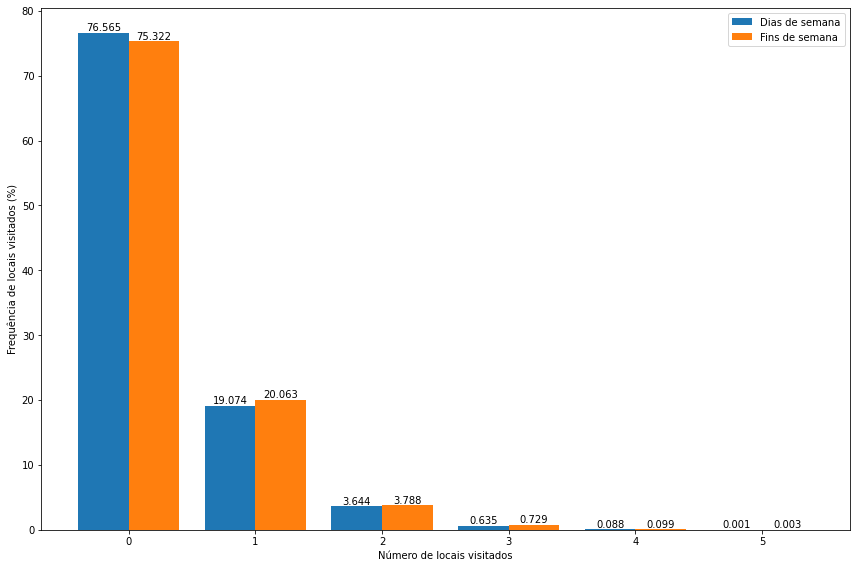

In [45]:
labels = frequency_sjdr_3['QUANTITY_LOCALS'].to_list()
x_ticks = np.arange(len(frequency_sjdr_3['QUANTITY_LOCALS'].to_list()))*2
width = 0.40

fig, ax = plt.subplots(figsize=(12,8))

rects1 = ax.bar(x_ticks - width, frequency_sjdr_3['%'].to_list(), label='Dias de semana')
rects2 = ax.bar(x_ticks + width, frequency_weekend_sjdr_3['%'].to_list(), label='Fins de semana')

ax.set_ylabel('Frequência de locais visitados (%)')
ax.set_xlabel('Número de locais visitados')
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels)
ax.legend()


ax.bar_label(rects1)
ax.bar_label(rects2)

fig.tight_layout()
#plt.title("Frequência de locais visitados por quantidade de locais \nda classe econômica 3 - Região imediata de São João del Rei")
plt.savefig('/home/gustavo/Desktop/Mestrado/mestrado_dados/grafico_classe3.png')
plt.show()


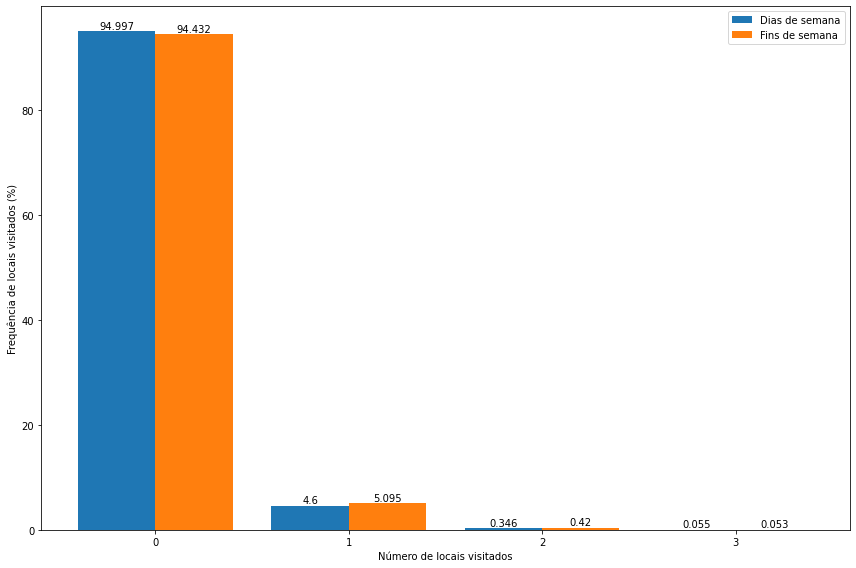

In [29]:
labels = frequency_sjdr_2['QUANTITY_LOCALS'].to_list()
x_ticks = np.arange(len(frequency_sjdr_2['QUANTITY_LOCALS'].to_list()))*2
width = 0.40

fig, ax = plt.subplots(figsize=(12,8))

rects1 = ax.bar(x_ticks - width, frequency_sjdr_2['%'].to_list(), label='Dias de semana')
rects2 = ax.bar(x_ticks + width, frequency_weekend_sjdr_2['%'].to_list(), label='Fins de semana')

ax.set_ylabel('Frequência de locais visitados (%)')
ax.set_xlabel('Número de locais visitados')
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels)
ax.legend()


ax.bar_label(rects1)
ax.bar_label(rects2)

fig.tight_layout()
#plt.title("Frequência de locais visitados por quantidade de locais \nda classe econômica 2 - Região imediata de São João del Rei")
plt.savefig('/home/gustavo/Desktop/Mestrado/mestrado_dados/grafico_classe2.png')
plt.show()


In [ ]:
frequency_sjdr_3['QUANTITY_LOCALS'].to_list()

In [ ]:
G = nx.MultiDiGraph()
G.add_nodes_from(df_tr2['USER_REDUCED'], bipartite = 1)
user = [v for v in G.nodes if G.nodes[v]['bipartite'] == 1]

G.add_nodes_from(df_tr2['ANTENNA_ID'], bipartite = 0)
antennas = [v for v in G.nodes if G.nodes[v]['bipartite'] == 0]

G.add_edges_from(df_tr2[['USER_REDUCED','ANTENNA_ID']].values)

d = graphviz.Digraph(format='png')
for n in user:
    d.node(str(n), color='red', label=n, size='2')

for n in antennas:
    d.node(str(n), color='green', label=n, size='2')

for (u,v) in G.edges():
    d.edge(str(u), str(v))

d.attr(size='10')

d.engine='circo'
d

In [ ]:
G.number_of_edges()